This file uses the movies_metadata.csv file for data analysis and development for linear regression based prediction model.

In [8]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from ast import literal_eval
import sklearn
import warnings
warnings.filterwarnings('ignore')

In [9]:
## Load data as a dataframe and clean data
df = pd.read_csv('movies_metadata.csv', low_memory = False);

## Remove homepage column from the dataframe
df = df.drop(columns=['homepage']) # delete homepage column as we do not need it
total_entries = len(df)

print('The total number of entries in original movies metadata is ' + str(total_entries) + '.') # total number of entries in metadata file
print('The total number of unique movies in the movies metadata is ' + str(len(df['id'].unique())) + '.')
df['status'].unique()

## Remove all unreleased movies
len(df.loc[df['status'] != 'Released']) # length of unreleased movies
df = df.drop(index = df.loc[df['status'] != 'Released'].index) # delete the movie entries which were not released
released_num = len(df)

The total number of entries in original movies metadata is 45466.
The total number of unique movies in the movies metadata is 45436.


In [10]:
# Reset the indexes here. We will try to access indexes later in the notebook and we run into issues if they are not consecutive.
df.loc[df.index == 189]
df = df.reset_index()
df = df.drop(columns=['index'])

4466 belong to a collection.
40548 do not belong to a collection.


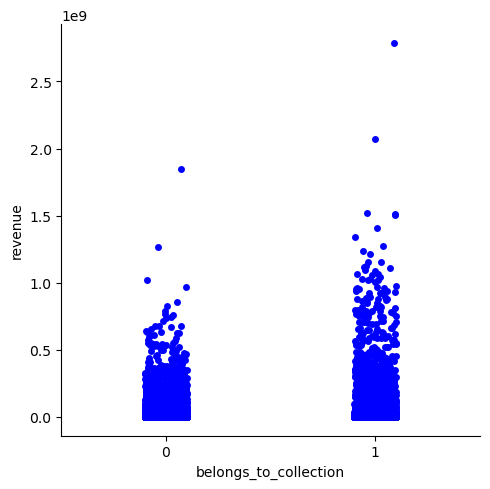

In [11]:
## visualize how revenue changes if the movie belongs to a collection or not

# store movies belonging to a collection as 1
num_movies_belonging_to_collection = len(df.loc[df['belongs_to_collection'].isna() == False])
df.loc[df['belongs_to_collection'].isna() == False, 'belongs_to_collection'] = 1
# store movies not belonging to a collection as 0
num_movies_not_belonging_to_collection = len(df.loc[df['belongs_to_collection'].isna() == True])
df.loc[df['belongs_to_collection'].isna() == True, 'belongs_to_collection'] = 0

print(str(num_movies_belonging_to_collection) + ' belong to a collection.')
print(str(num_movies_not_belonging_to_collection) + ' do not belong to a collection.')

catplot_collection = sns.catplot(df[{'belongs_to_collection', 'revenue'}], x = "belongs_to_collection", y = "revenue", color='blue')

catplot_collection.savefig("belongs_to_collection.pdf", dpi=200, bbox_inches="tight")

Some movies belonging to a collection make higher revenue. However there is a still a big number of movies from both categories which do not make much revenue. So, the categorical/binary variable belongs_to_collection does not seem to affect the revenue much.

8 movies belong to an adult category.
45006 movies do not belong to an adult category.


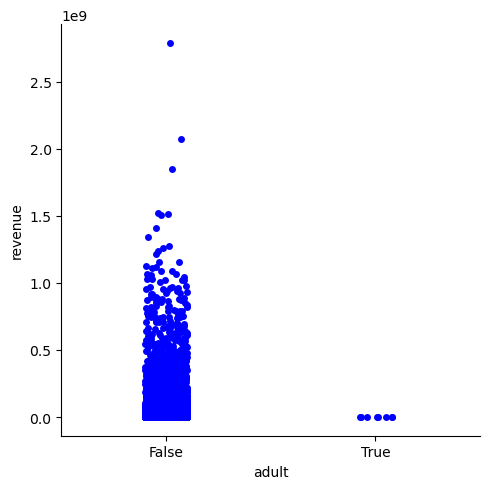

In [12]:
## visualize how revenue changes if the movie belongs to adult category

num_adult_movies = len(df.loc[df['adult'] == "True"])
num_non_adult_movies = len(df.loc[df['adult'] == "False"])

print(str(num_adult_movies) + ' movies belong to an adult category.')
print(str(num_non_adult_movies) + ' movies do not belong to an adult category.')

sns.catplot(df[{'adult', 'revenue'}], x = "adult", y = "revenue", color="blue")

df.loc[df['adult'] == "False", 'adult'] = 0
df.loc[df['adult'] == "True", 'adult'] = 1

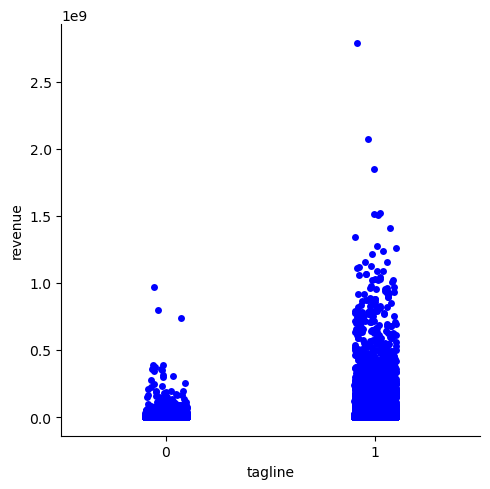

In [13]:
# visualize revenue by tagline

# store movies having tagline as 1
df.loc[df['tagline'].isna() == False, 'tagline'] = 1
# store movies not having tagline as 1
df.loc[df['tagline'].isna() == True, 'tagline'] = 0
df['tagline']
sns.catplot(df[{'tagline', 'revenue'}], x = "tagline", y = "revenue", color="blue")

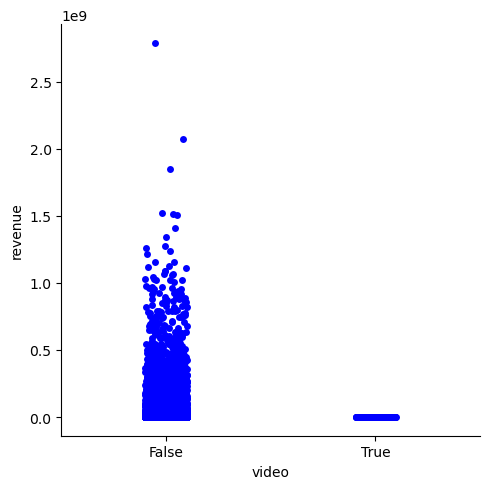

In [14]:
#number of whether its a movie or video vs revenue
sns.catplot(df[{'video', 'revenue'}], x = "video", y = "revenue", color="blue")

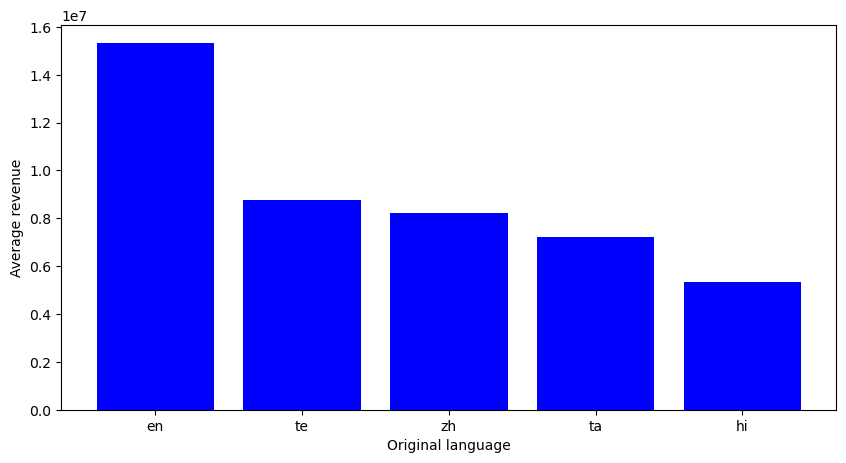

In [15]:
## visualize how average revenue changes based on original language

average_revenue = pd.DataFrame(columns = ['original_language', 'revenue'])

for language in df['original_language'].unique():
    mean_revenue = df.loc[df['original_language'] == language, 'revenue'].mean()
    average_revenue = average_revenue.append({"original_language" : language, "revenue" : mean_revenue,}, ignore_index=True)
    
average_revenue.dtypes
top_ten_highest_average_revenue = average_revenue.sort_values(by = "revenue", ascending=False)[:5]
top_ten_highest_average_revenue

fig = plt.figure(figsize = (10, 5))
plt.bar(top_ten_highest_average_revenue['original_language'], top_ten_highest_average_revenue['revenue'], color='blue')
plt.ylabel("Average revenue")
plt.xlabel('Original language')
#plt.title("Average revenue vs Genres")
plt.show()
fig.savefig("languageandrevenue.pdf", dpi=200, bbox_inches="tight")

English movies in general make higher revenue than other languages. This could be because of accessibility and global use of english, resulting in a bigger market for English movies.

In [17]:
## Attempt to learn the actual name of the abbreviated languages
## Does not work well though

# find language name
df_language = df['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
# find abbreviated language name
df_language_short = (df['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['iso_639_1'] for i in x] if isinstance(x, list) else []))

all_language = []
for item in df_language:
    for subitem in item:
        all_language.append(subitem)

all_language_unique = set(all_language)
#print(all_language_unique)

all_language_short = []
for item in df_language_short:
    for subitem in item:
        all_language_short.append(subitem)
        
all_language_short_unique = set(all_language_short)

#print(all_language_short_unique)
pd.DataFrame([all_language_unique, all_language_short_unique])

,0,1,2,3,4,5,6,7,8,9,...,123,124,125,126,127,128,129,130,131,132
0,,Tiếng Việt,English,Íslenska,ਪੰਜਾਬੀ,Pусский,Český,Română,svenska,Gaeilge,...,None,None,None,None,None,None,None,None,None,None
1,tr,xh,sa,az,af,ce,bg,ab,gd,ay,...,ar,sc,be,ln,lt,iu,ps,ro,eu,ml


There are {'Science Fiction', 'Foreign', 'Adventure', 'Comedy', 'Animation', 'Drama', 'Music', 'Documentary', 'TV Movie', 'History', 'Horror', 'War', 'Romance', 'Thriller', 'Fantasy', 'Mystery', 'Crime', 'Family', 'Action', 'Western'} in total.


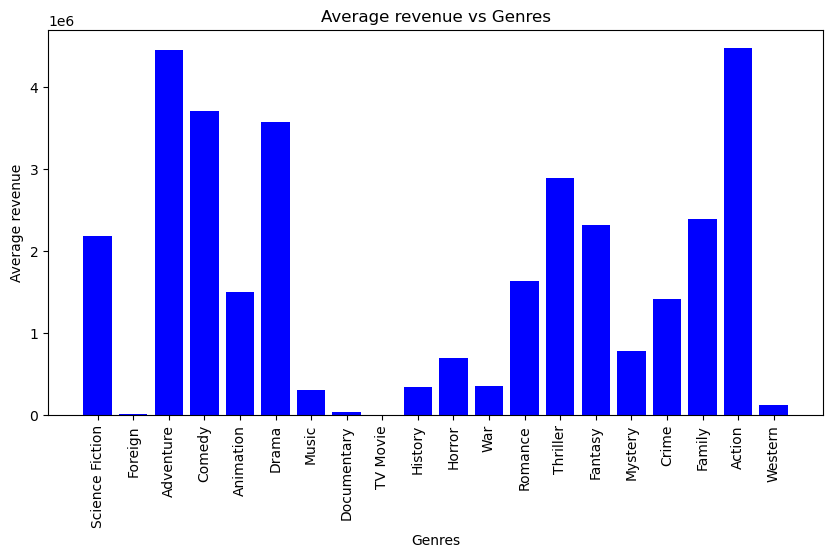

,0
count,2.000000e+01
mean,1.654316e+06
std,1.520537e+06
min,9.330638e+02
25%,3.225562e+05
50%,1.454454e+06
75%,2.507234e+06
max,4.475517e+06


In [18]:
## visualize average revenue by genre

# remove ids and labels like name
df['genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df['genres']

# create a list of all possible genres
all_genres=[]
for item in df['genres']:
    for subitem in item:
        all_genres.append(subitem)

# list of unique genres
unique_genres = set(all_genres)
print('There are ' + str(unique_genres) +' in total.')

# find the average revenue by genre
mean_revenue = []
for genre in unique_genres:
    movie_revenue_needed = []
    for j in range(len(df['genres'])):
        if genre in df['genres'][j]:
            movie_revenue_needed.append(df['revenue'][j])
    mean_revenue.append(sum(movie_revenue_needed)/j)

# plot for average revenue vs genre
fig = plt.figure(figsize=(10, 5))
plt.bar(list(unique_genres), mean_revenue, color='blue')
plt.xlabel("Genres")
plt.ylabel("Average revenue")
plt.title("Average revenue vs Genres")
plt.xticks(rotation = 90)
plt.show()

pd.DataFrame(mean_revenue).describe()

Adventure and Action genres seem to have highest average revenue, followed by Comedy, Drama, and Family. Categories like Foreign, Documentary, Western, History, War and Music, belong to the first quartile, making very low revenue.

There are {'', 'Tiếng Việt', 'English', 'Íslenska', 'ਪੰਜਾਬੀ', 'Pусский', 'Český', 'Română', 'svenska', 'Gaeilge', 'ภาษาไทย', 'isiZulu', 'Bahasa melayu', '?????', 'Latviešu', 'Español', 'فارسی', 'Bosanski', 'Slovenčina', 'suomi', 'български език', '日本語', 'עִבְרִית', 'اردو', 'Português', 'العربية', '普通话', 'Somali', 'Türkçe', 'Esperanto', 'ქართული', 'Galego', 'Cymraeg', 'Eesti', 'Український', 'Italiano', 'Wolof', 'No Language', 'беларуская мова', 'қазақ', 'Norsk', 'Slovenščina', '??????', 'Français', 'Fulfulde', 'हिन्दी', 'Bokmål', 'Malti', 'తెలుగు', 'Deutsch', 'Afrikaans', 'Kinyarwanda', 'Hausa', 'Bamanankan', 'தமிழ்', 'Bahasa indonesia', 'Català', 'Dansk', 'Nederlands', 'Magyar', 'Srpski', 'Azərbaycan', 'Kiswahili', 'Latin', 'ελληνικά', 'پښتو', 'Polski', 'shqip', '广州话 / 廣州話', '한국어/조선말', 'euskera', 'Lietuvi\x9akai', 'বাংলা', 'ozbek', 'Hrvatski'} in total.


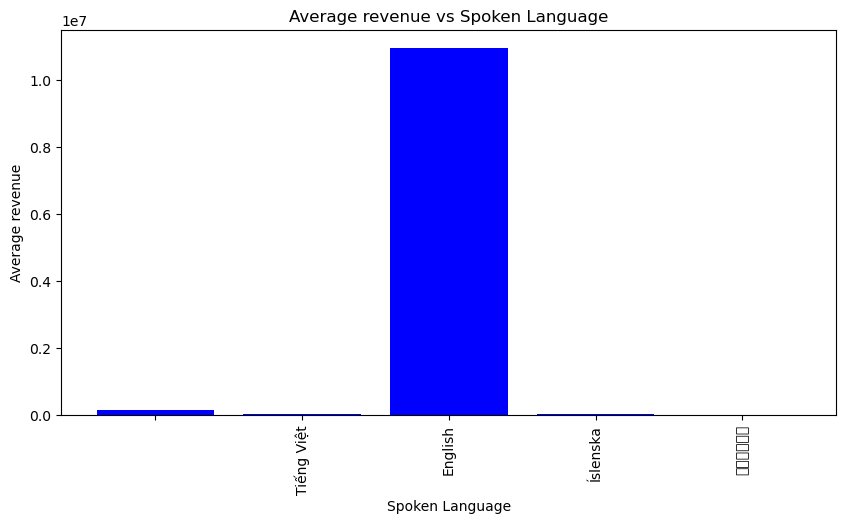

In [19]:
## visualize average revenue by language # This is probably unnecessary though.

# remove ids and labels like name
df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df['spoken_languages']

# df['genres'] = df['genres'].str.replace("'name'|'id'|:|1|2|3|4|5|6|7|8|9|0", '')
# df['genres'] = df['genres'].str.replace("[|[{,|{,|}|]|]", "")
# df['genres']= df['genres'].str.split()
# df['genres']

# create a list of all possible languages
all_languages = []
for item in df['spoken_languages']:
    for subitem in item:
        all_languages.append(subitem)

# list of unique languages
unique_languages = set(all_languages)
print('There are ' + str(unique_languages) +' in total.')

# find the average revenue by spoken language
mean_revenue = []
for language in unique_languages:
    movie_revenue_needed = []
    for j in range(len(df['spoken_languages'])):
        if language in df['spoken_languages'][j]:
            movie_revenue_needed.append(df['revenue'][j])
    mean_revenue.append(sum(movie_revenue_needed)/j)

# plot for average revenue vs genre
fig = plt.figure(figsize=(10, 5))
plt.bar(list(unique_languages)[:5], mean_revenue[:5], color='blue')
plt.xlabel("Spoken Language")
plt.ylabel("Average revenue")
plt.title("Average revenue vs Spoken Language")
plt.xticks(rotation = 90)
plt.show()

count    4.501400e+04
mean     4.265195e+06
std      1.750569e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.800000e+08
Name: budget, dtype: float64

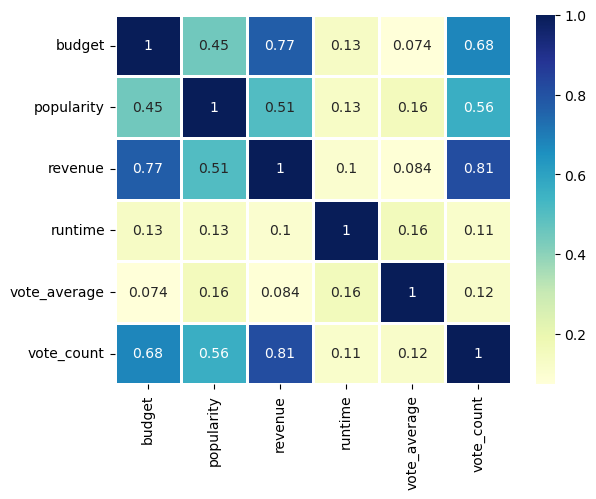

In [20]:
# Correlation matrix before deleting any columns
df1 = df

# change all numerical attributes to floating numbers
df1['budget'] = df['budget'].astype('float64')
df1['popularity'] = df['popularity'].astype('float64')

# correlation heatmap
corr1 = sns.heatmap(df1.corr(), cmap='YlGnBu', annot=True, linewidths = 1);
correlation1 = corr1.get_figure()
correlation1.savefig('correlation1.pdf', dpi=200, bbox_inches="tight")

# statistical properties of budget column
df1['budget'].describe()

In [21]:
## Drop columns that we do not need.

# 1. # delete status column as we are only using released movies.
# 2. # delete imdb_id column as we will only use the id column if needed.
# 3. # delete the original titles as they are not in english.
# 4. # delete overview as movie description is not needed.
# 5. # delete poster path as this is not needed.
# 6. # delete tagline as we do not need it.
# All non numerical attributes are removed

df = df.drop(columns=['status', 'imdb_id', 'original_title', 'overview', 'poster_path', 'tagline', 'belongs_to_collection']) 

In [22]:
# This section checks the datatypes for each columns and changes the required columns to float64.

df.dtypes
df['budget'] = df['budget'].astype('float64')

# remove movies with 0 budget
df = df.loc[df['budget'] != 0]
df['popularity'] = df['popularity'].astype('float64')

# remove movies with 0 revenue
df = df.loc[df['revenue'] != 0]
print(df.dtypes)
print("The total number of movies with budget listed is " + str(len(df)) + ' .')

adult                    object
budget                  float64
genres                   object
id                       object
original_language        object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                 float64
runtime                 float64
spoken_languages         object
title                    object
video                    object
vote_average            float64
vote_count              float64
dtype: object
The total number of movies with budget listed is 5377 .


In the above code, we also deleted movies which have budget listed as 0, and revenue listed as 0. We could have filled in those values with mean budget and mean revenue by genre.

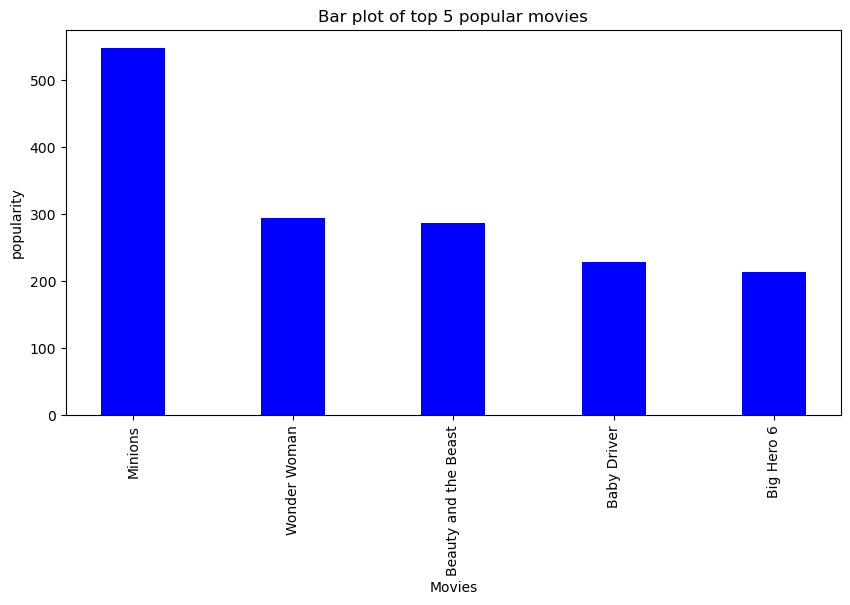

In [23]:
## top 5 popular movies

top_ten_movies_popularity = df.sort_values(by=['popularity'], ascending=False)[:5]
top_ten_movies_popularity
fig = plt.figure(figsize = (10, 5))
plt.bar(top_ten_movies_popularity['title'], top_ten_movies_popularity['popularity'], color ='blue', 
        width = 0.4) 
plt.xlabel("Movies")
plt.ylabel("popularity")
plt.title("Bar plot of top 5 popular movies")
plt.xticks(rotation = 90)
plt.show()
#fig.savefig('popular_movies.pdf', dpi=200, bbox_inches="tight")

The plot above gives the movies with highest popularity from the dataset. Minions have highest popularity based on the plots above.

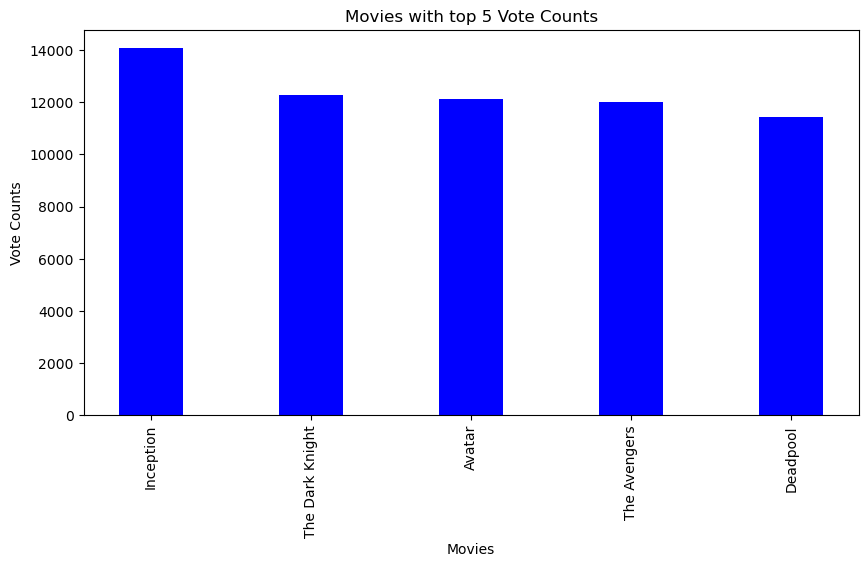

In [25]:
## Five movies with highest vote counts

top_ten_movies_vote_counts = df.sort_values(by=['vote_count'], ascending=False)[:5]
top_ten_movies_vote_counts
fig = plt.figure(figsize = (10, 5))
plt.bar(top_ten_movies_vote_counts['title'], top_ten_movies_vote_counts['vote_count'], color ='blue', 
        width = 0.4) 
plt.xlabel("Movies")
plt.ylabel("Vote Counts")
plt.title("Movies with top 5 Vote Counts")
plt.xticks(rotation = 90)
plt.show()

The plot above gives the movies with highest vote counts. Inception has the highest vote counts.

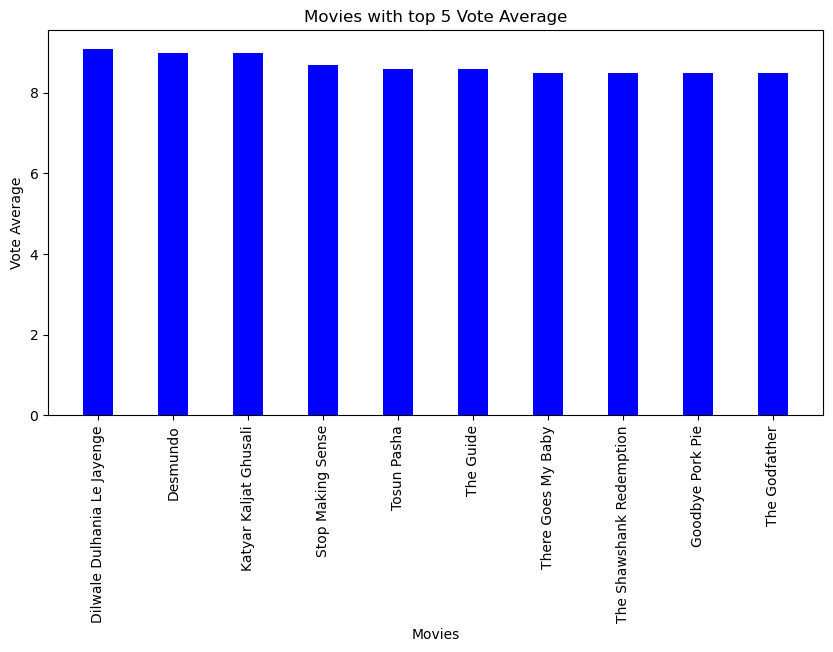

In [26]:
## Five movies with highest vote average

top_ten_movies_vote_average = df.sort_values(by=['vote_average'], ascending=False)[:10]
top_ten_movies_vote_average
fig = plt.figure(figsize = (10, 5))
plt.bar(top_ten_movies_vote_average['title'], top_ten_movies_vote_average['vote_average'], color ='blue', 
        width = 0.4) 
plt.xlabel("Movies")
plt.ylabel("Vote Average")
plt.title("Movies with top 5 Vote Average")
plt.xticks(rotation = 90)
plt.show()

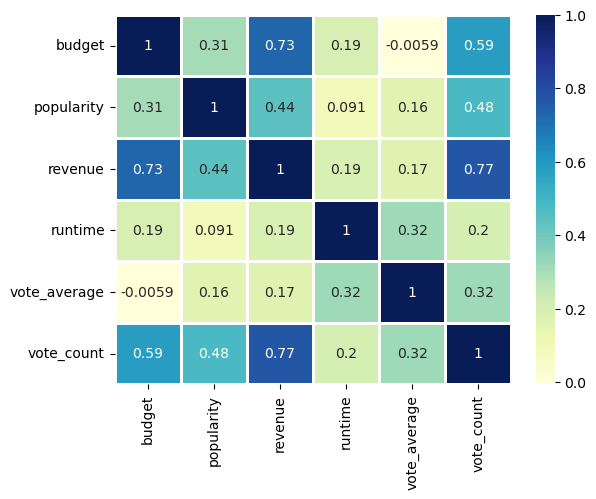

In [27]:
# correlation matrix of movies with non 0 budget and non 0 revenue

corr2 = sns.heatmap(df.corr(), cmap='YlGnBu', annot=True, linewidths = 1);
correlation2 = corr2.get_figure()
correlation2.savefig('correlation2.pdf', dpi=200, bbox_inches="tight")

The correlation heatmap aboce shows that movie revenue has positive correlation with all other variables. It seems that budget and vote counts affect the revenue the most.

[Text(0.5, 1.0, 'Distribution of revenue')]

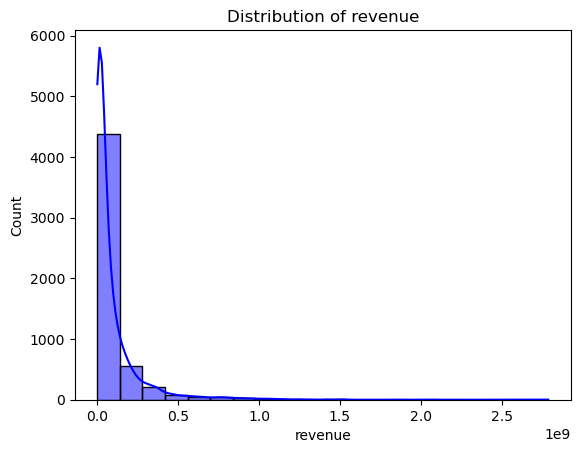

In [34]:
# Distribution of revenue

sns.histplot(data=df['revenue'], bins = 20, kde=True, color="blue").set(title="Distribution of revenue")

The plot above shows that the revenue data is heavily skewed. This is prevalent in many real datsets.
From the plot above, we see that majority of movies makes less revenue and only a small group of movies
makes majority of revenue. To see this better, we visualize this plot on a log scale.

[Text(0.5, 1.0, 'Distribution of revenue in log scale')]

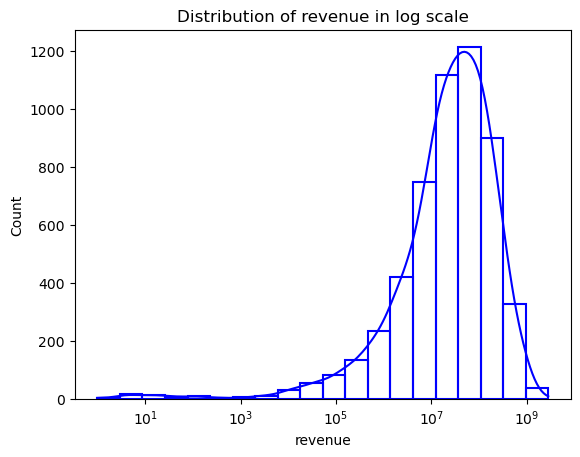

In [35]:
# Distribution of revenue in log scale

sns.histplot(data=df['revenue'], bins = 20, log_scale=True, fill=False, kde = True, color="blue").set(title="Distribution of revenue in log scale")

The distribution of revenue in log scale.

In [74]:
# Discriptive analysis of revenues dataset.

df['revenue'].describe()

count    5.377000e+03
mean     9.038159e+07
std      1.661876e+08
min      1.000000e+00
25%      7.022209e+06
50%      2.995000e+07
75%      1.000000e+08
max      2.787965e+09
Name: revenue, dtype: float64

The total number of movies we have left is 5377. The revenue ranges from anywhere between 1 to 2787965000. The mean is 90381590 whereas the median is 29950000, which implies that the revenue data is right skewed. This was also observed in the dataset above.

In [37]:
# Split into training and testing dataset

from sklearn.model_selection import train_test_split

# proportion of testing datasize
test_proportion = 0.8;

df_train, df_test = train_test_split(df, test_size = test_proportion)
df_test['budget']

8143     15000000.0
20839     4800000.0
39588    90000000.0
3227      2300000.0
4887     18000000.0
            ...    
291       8000000.0
13903    30000000.0
2165      8000000.0
756       4000000.0
10023    43000000.0
Name: budget, Length: 4302, dtype: float64

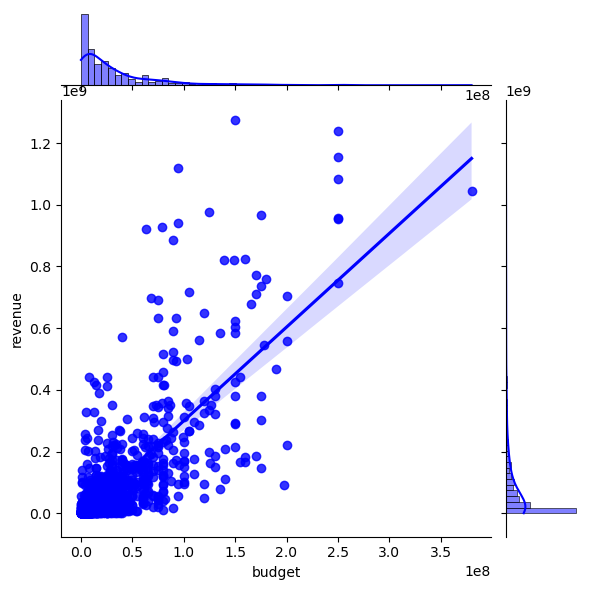

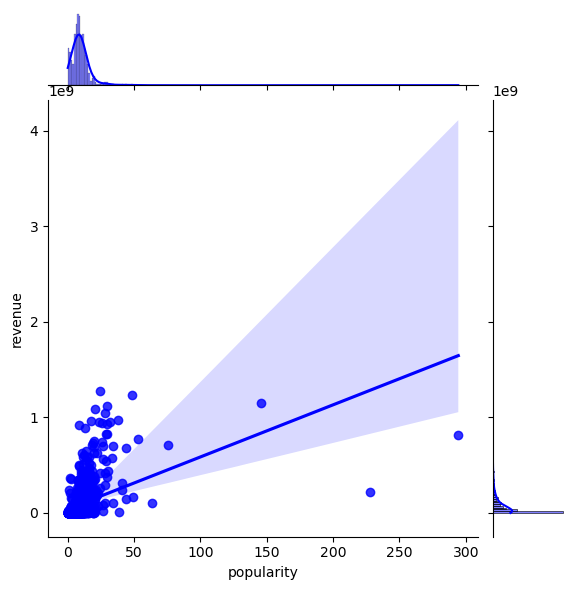

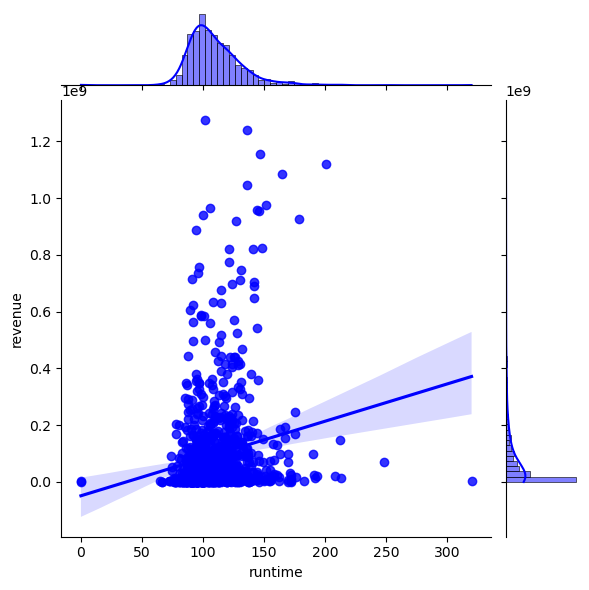

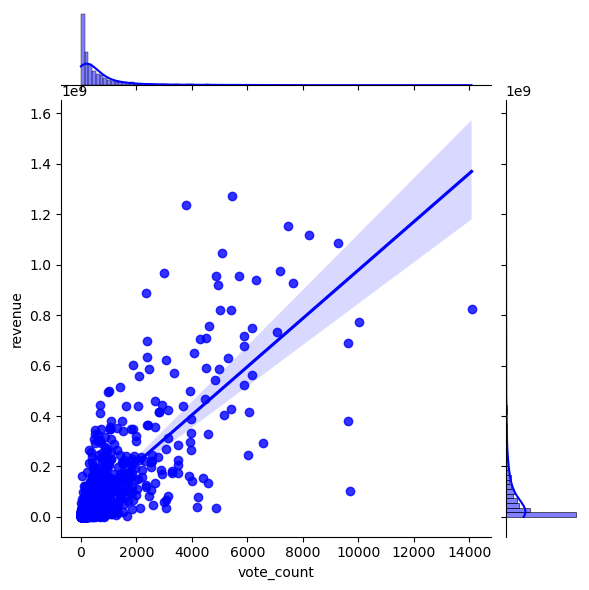

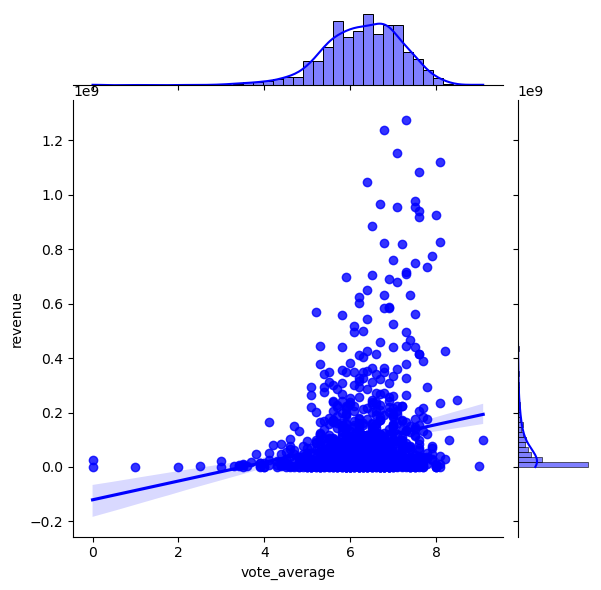

In [38]:
## Plots to visualize relationships between independent and dependent variables in the training data set.
## Independent variables: Budget, Popularity, Runtime, Vote_count, Vote_average
## Dependent variable: Revenue

plt1 = sns.jointplot(df_train[{'budget', 'revenue'}], x="budget", y="revenue", kind="reg", color="blue");
plt2 = sns.jointplot(df_train[{'popularity', 'revenue'}], x="popularity", y="revenue", kind="reg", color="blue");
plt3 = sns.jointplot(df_train[{'runtime', 'revenue'}], x="runtime", y="revenue", kind = "reg", color="blue");
plt4 = sns.jointplot(df_train[{'vote_count', 'revenue'}], x="vote_count", y="revenue", kind = "reg", color="blue");
plt5 = sns.jointplot(df_train[{'vote_average', 'revenue'}], x="vote_average", y="revenue", kind="reg", color="blue");
plt1.savefig('budgetandrevenue.pdf', dpi=200, bbox_inches="tight")
plt2.savefig('popularityandrevenue.pdf', dpi=200, bbox_inches="tight")
plt3.savefig('runtimeandrevenue.pdf', dpi=200, bbox_inches="tight")
plt4.savefig('votecountandrevenue.pdf', dpi=200, bbox_inches="tight")
plt5.savefig('voteaverageandrevenue.pdf', dpi=200, bbox_inches="tight")
plt.show()

What does this tell us about the results?

Looking at the plots, it seems that vote_count and budget have linear relationship with revenue, whereas vote_average seems to have non-linear (possibly quadratic) relationship with revenue. It is diffcult to determine the relationship between runtime and revenue, and popularity and revenue.

In [39]:
# Fit linear regression on training data and test on testing data.

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import r2_score

# train our model
df_train = df_train.fillna(0)
reg = LinearRegression().fit(df_train[{'budget', 'popularity', 'vote_count', 'runtime', 'vote_average'}], df_train['revenue'])
coefficient = reg.coef_

# coefficients
print('The coefficient of budget is '+ str(coefficient[0]) + '.')
print('The coefficient of popularity is '+ str(coefficient[1]) + '.')
print('The coefficient of vote_count is '+ str(coefficient[2]) + '.')
print('The coefficient of runtime is '+ str(coefficient[3]) + '.')
print('The coefficient of vote average is '+ str(coefficient[4]) + '.')

# intercept
intercept = reg.intercept_
print('Intercept is ' + str(intercept) + '.')

# fill in the empty section of testing data
df_test = df_test.fillna(0)
revenue_prediction = reg.predict(df_test[{'budget', 'popularity', 'vote_count', 'runtime', 'vote_average'}])
df_revenue_prediction = pd.DataFrame(revenue_prediction)

# table with predicted and actual values
table_actual_pred = pd.concat([df_test['revenue'].reset_index(), df_revenue_prediction], axis=1)
table_actual_pred = table_actual_pred.rename(columns={0 : "predicted"})
print(table_actual_pred)

# RMSE calculation
MSE = mean_squared_error(revenue_prediction, df_test['revenue'])
RMSE = math.sqrt(MSE)
print('The RMSE for the regression is ' + str(RMSE) + '.')

# used the formula of RMSE to check if we have same answer. As RMSE is large, we want to double check.
print(np.sqrt((((table_actual_pred['revenue']-table_actual_pred['predicted'])**2)/len(table_actual_pred)).sum()))

# R2 score
R2_score = r2_score(df_test['revenue'], revenue_prediction);
print("The R2_score for our model is " + str(R2_score) + '.')

print(str(R2_score*100) + " of the variance in revenue is explained by the variance in budget, popularity, vote_count, runtime and vote_average" + ".")

The coefficient of budget is 60653.74274810789.
The coefficient of popularity is 668644.8193069063.
The coefficient of vote_count is 1677087.053260193.
The coefficient of runtime is 1.7909287366144666.
The coefficient of vote average is -119539.10720873758.
Intercept is -14587129.046594158.
      index      revenue     predicted
0      8143   14867514.0  2.636462e+07
1     20839   10337387.0  5.044004e+07
2     39588  162360636.0  2.929674e+08
3      3227   20000000.0 -1.945403e+06
4      4887   14110013.0  2.208770e+07
...     ...          ...           ...
4297    291  213928762.0  6.153647e+08
4298  13903  210819611.0  2.550606e+08
4299   2165   21706101.0  1.090606e+07
4300    756   16491080.0  1.734873e+08
4301  10023  154749918.0  8.902248e+07

[4302 rows x 3 columns]
The RMSE for the regression is 89231817.19594951.
89231817.19594951
The R2_score for our model is 0.7079736992114709.
70.7973699211471 of the variance in revenue is explained by the variance in budget, popularity, v

For the linear regression above, we chose budget, popularity , vote counts, runtime and vote average as the independent variables whereas revenue being the dependent variable. The coefficient of budget is negative, which does not make sense, based on the joint plot above. So in the code below, we take only two variables: budget and vote counts, which seemed to be most important in the joint plots above. The RMSE is large, which could be due to missing data, which are filled in with 0s.

In [40]:
# Regression with budget and vote counts as the only independent variables

# train our model
reg1 = LinearRegression().fit(df_train[{'budget', 'vote_count'}], df_train['revenue'])
coefficient1 = reg1.coef_

# coefficients corresponding to each variable
print('The coefficient of budget is '+ str(coefficient1[0]) + '.')
print('The coefficient of vote_count is '+ str(coefficient1[1]) + '.')

# intercept
intercept1 = reg1.intercept_
print('Coefficient is ' + str(intercept1) + '.')

# test our model
revenue_prediction1 = reg1.predict(df_test[{'budget', 'vote_count'}])

df_revenue_prediction = pd.DataFrame(revenue_prediction1)

# table with predicted and actual values
table_actual_pred = pd.concat([df_test['revenue'].reset_index(), df_revenue_prediction], axis=1)
table_actual_pred = table_actual_pred.rename(columns={0 : "predicted"})
print(table_actual_pred)

# calculate RMSE
MSE1 = mean_squared_error(revenue_prediction1, df_test['revenue'])
RMSE1 = math.sqrt(MSE1)
print('The RMSE for the regression is ' + str(RMSE1) + '.')

# used the formula of RMSE to check if we have same answer. As RMSE is large, we want to double check.
print(np.sqrt((((table_actual_pred['revenue']-table_actual_pred['predicted'])**2)/len(table_actual_pred)).sum()))

# R2 score
R2_score = r2_score(df_test['revenue'], revenue_prediction1);
print("The R2_score for our model is " + str(R2_score) +'.')

print(str(R2_score*100) + "of the variance in revenue is explained by the variance in budget and vote_count" + ".")

The coefficient of budget is 63372.486658793794.
The coefficient of vote_count is 1.8045404422246163.
Coefficient is -13044074.722574174.
      index      revenue     predicted
0      8143   14867514.0  2.802935e+07
1     20839   10337387.0  5.176574e+07
2     39588  162360636.0  2.987969e+08
3      3227   20000000.0 -3.823833e+06
4      4887   14110013.0  2.381035e+07
...     ...          ...           ...
4297    291  213928762.0  5.508317e+08
4298  13903  210819611.0  2.597906e+08
4299   2165   21706101.0  1.210220e+07
4300    756   16491080.0  1.676246e+08
4301  10023  154749918.0  9.072400e+07

[4302 rows x 3 columns]
The RMSE for the regression is 89972662.48160602.
89972662.48160602
The R2_score for our model is 0.703104485059149.
70.3104485059149of the variance in revenue is explained by the variance in budget and vote_count.


Both variables budget and vote_count have positive coefficients. Although the RMSE is lower than for previous regression, it is still large.

In [41]:
# As the RMSE is high for both regressions, we try the kNeighbors Regressor

from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors = 5)
knn_model = knn.fit(df_train[{'budget', 'vote_count'}], df_train['revenue'])
knn_revenue_prediction = knn.predict(df_test[{'budget', 'vote_count'}])
MSE2 = mean_squared_error(knn_revenue_prediction, df_test['revenue'])
RMSE2 = math.sqrt(MSE2)
print('The RMSE for the KNeighbors Regressor is ' + str(RMSE2) + '.')

The RMSE for the KNeighbors Regressor is 111675549.87236208.


In [42]:
# Try RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf_model = rf.fit(df_train[{'budget', 'vote_count'}], df_train['revenue'])
rf_revenue_prediction = rf.predict(df_test[{'budget', 'vote_count'}])
MSE3 = mean_squared_error(rf_revenue_prediction, df_test['revenue'])
RMSE3 = math.sqrt(MSE3)
print('The RMSE for the RandomForestRegressor is ' + str(RMSE3) + '.')

The RMSE for the RandomForestRegressor is 93675139.00775923.


In [43]:
# prediction using SVM # Just tried for comparison, not for the project
from sklearn import svm

svm = svm.SVR()
svm_model = svm.fit(df_train[{'budget', 'vote_count'}], df_train['revenue'])
svm_revenue_prediction = svm.predict(df_test[{'budget', 'vote_count'}])
MSE4 = mean_squared_error(svm_revenue_prediction, df_test['revenue'])
RMSE4 = math.sqrt(MSE4)
print(RMSE4)

175136805.86143038
